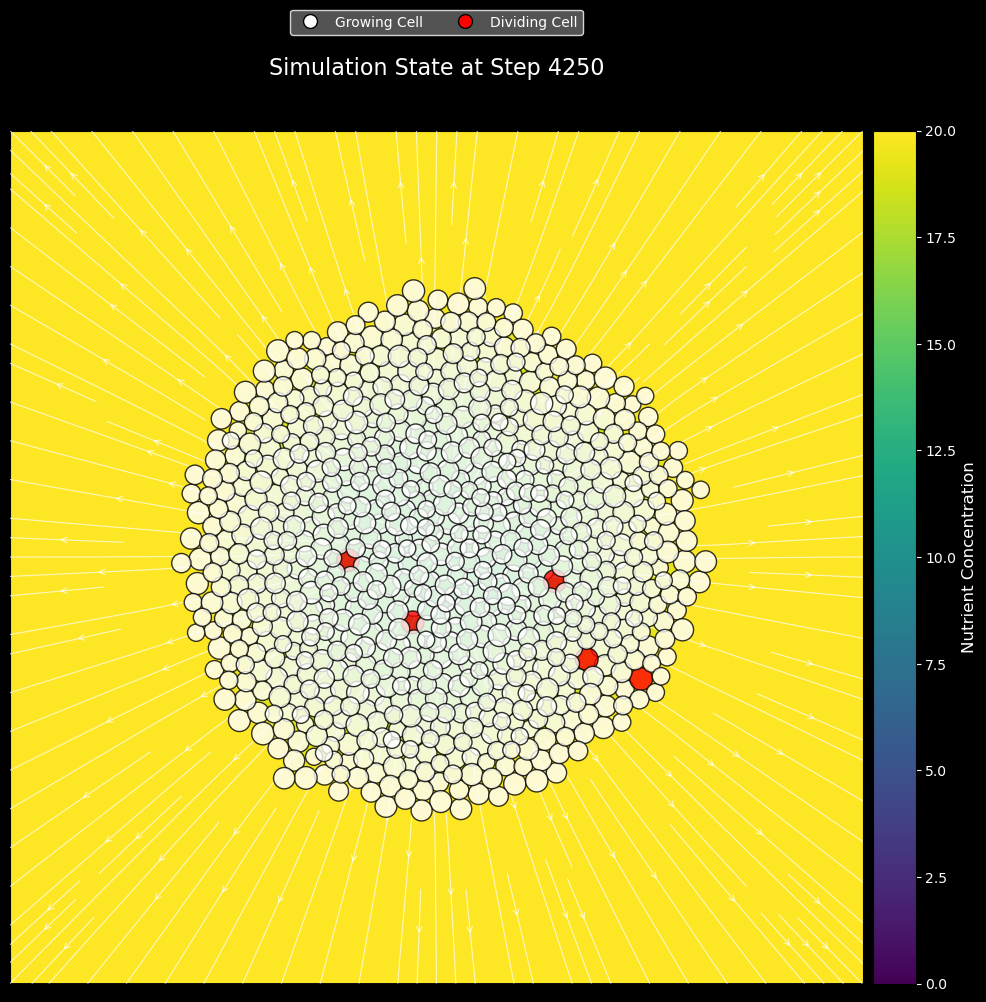

Saved visualization to Hydro_OFF_step_4250.png


In [115]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

def load_data_for_step(output_dir, simulation_name, step_number):
    """Loads all saved data for a specific time step."""
    filename = os.path.join(output_dir, f"{simulation_name}_data_{step_number:04d}.npz")
    if not os.path.exists(filename):
        print(f"Error: Data file not found: {filename}")
        return None
    
    try:
        # allow_pickle=True is needed to load the config dictionary
        with np.load(filename, allow_pickle=True) as data:
            # Create a dictionary from the loaded data for easy access
            # The .item() is needed for the 'config' array
            return {key: data[key].item() if key == 'config' else data[key] for key in data.files}
    except Exception as e:
        print(f"Error loading data from {filename}: {e}")
        return None


def plot_simulation_state(data, step_number, plot_config, max_radius, output_filename="visualization.png"):
    """
    Creates a multi-layered plot showing the full state of the simulation,
    with control over which layers are visible.
    """
    if data is None:
        return

    # --- Unpack data for easier access ---
    nutrient_field = data['final_nutrient_field']
    attractant_field = data['final_attractant_field']
    fluid_velocity = data['final_fluid_velocity']
    cell_positions = data['cell_positions']
    cell_radii = data['cell_radii']
    domain_size = nutrient_field.shape
    physical_size = float(domain_size[0]) # Assuming square domain

    # --- Create the Plot ---
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('#101010') # Dark gray background
    ax.set_title(f"Simulation State at Step {step_number}", color='white', fontsize=16, pad=40)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')
    
    divider = make_axes_locatable(ax)

    # --- Use plot_config to conditionally plot each layer ---

    # 1. Plot Nutrient Field (Base Layer)
    if plot_config.get('show_nutrient', False):
        im_nutrient = ax.imshow(nutrient_field, cmap='viridis', origin='lower', 
                                vmin=0, vmax=data['config'].get('nutrient_bc_value', 20.0), 
                                extent=[0, physical_size, 0, physical_size], zorder=1)
        
        cax_n = divider.append_axes("right", size="5%", pad=0.1)
        cbar_n = fig.colorbar(im_nutrient, cax=cax_n)
        cbar_n.set_label('Nutrient Concentration', color='white', fontsize=12)
        cbar_n.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar_n.ax.axes, 'yticklabels'), color='white')


    # 2. Plot Attractant Field (Overlay)
    if plot_config.get('show_attractant', False):
        colors = [(0.1, 0.9, 0.9, 0), (0.1, 1, 1, 0.8)] # Transparent to bright cyan
        attractant_cmap = LinearSegmentedColormap.from_list('transparent_cyan', colors, N=100)
        
        im_attractant = ax.imshow(attractant_field, cmap=attractant_cmap, origin='lower', 
                                  vmin=0, vmax=np.max(attractant_field) if attractant_field.max() > 0 else 1.0,
                                  extent=[0, physical_size, 0, physical_size], zorder=2)
        
        cax_a = divider.append_axes("left", size="5%", pad=0.8)
        cbar_a = fig.colorbar(im_attractant, cax=cax_a)
        cbar_a.set_label('Attractant Concentration', color='white', fontsize=12)
        cax_a.yaxis.set_ticks_position('left')
        cax_a.yaxis.set_label_position('left')
        cbar_a.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar_a.ax.axes, 'yticklabels'), color='white')


    # 3. Plot Fluid Velocity (Streamlines)
    if plot_config.get('show_velocity', False) and np.any(fluid_velocity):
        num_points = 25
        y_coords = np.linspace(0, physical_size, num_points)
        x_coords = np.linspace(0, physical_size, num_points)
        x, y = np.meshgrid(x_coords, y_coords)
        
        # --- FIXED: Clip indices to prevent IndexError ---
        xi = (x / physical_size * domain_size[1]).astype(int)
        yi = (y / physical_size * domain_size[0]).astype(int)
        xi = np.clip(xi, 0, domain_size[1] - 1)
        yi = np.clip(yi, 0, domain_size[0] - 1)
        
        vx = fluid_velocity[yi, xi, 0]
        vy = fluid_velocity[yi, xi, 1]
        
        # --- FIXED: Removed 'alpha' and set transparency in 'color' for compatibility ---
        ax.streamplot(x, y, vx, vy, color=(1, 1, 1, 0.7), linewidth=0.8, density=1.5, arrowstyle='->', arrowsize=1.0, zorder=3)

    # 4. Plot Cells (Top Layer)
    if plot_config.get('show_cells', False):
        for i in range(len(cell_positions)):
            pos = cell_positions[i]
            rad = cell_radii[i]
            
            is_dividing = rad >= (max_radius - 0.01)
            face_color = 'red' if is_dividing else 'white'
            
            # --- FIXED: Add zorder to ensure cells are drawn on top ---
            circle = plt.Circle(pos, rad, facecolor=face_color, edgecolor='black', lw=1.0, fill=True, alpha=0.8, zorder=5)
            ax.add_artist(circle)

    # Add Legend for Cell Colors
    if plot_config.get('show_cells', False):
        legend_elements = [
            Line2D([0], [0], marker='o', color='None', label='Growing Cell', markerfacecolor='white', markersize=10),
            Line2D([0], [0], marker='o', color='None', label='Dividing Cell', markerfacecolor='red', markersize=10)
        ]
        ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15),
                  ncol=2, fancybox=True, facecolor='dimgray', edgecolor='white',
                  labelcolor='white')
    
    ax.set_xlim(0, physical_size)
    ax.set_ylim(0, physical_size)
    
    # Use tight_layout to ensure everything fits, adjusting for colorbars
    fig.tight_layout(rect=[0.05, 0, 0.9, 1]) 
    plt.savefig(output_filename, facecolor='black')
    plt.show()
    print(f"Saved visualization to {output_filename}")


if __name__ == '__main__':
    # --- USER CONFIGURATION ---
    simulation_name = 'Hydro_OFF'
    step_to_visualize = 4500

    plot_config = {
        'show_nutrient': True,
        'show_attractant': False,
        'show_velocity': True,
        'show_cells': True,
    }
    
    # This should match the value in the simulation's Cell class
    CELL_MAX_RADIUS = 4.0
    # ----------------------------------------

    output_dir = f"simulation_data_{simulation_name}"
    
    # Load the data
    simulation_data = load_data_for_step(output_dir, simulation_name, step_to_visualize)
    
    # Create the plot
    if simulation_data:
        plot_simulation_state(
            simulation_data, 
            step_to_visualize, 
            plot_config, 
            CELL_MAX_RADIUS, # Pass the max radius
            f"{simulation_name}_step_{step_to_visualize}.png"
        )
